In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob as glb
import scipy as sp
from scipy.ndimage.filters import gaussian_filter
import json


%matplotlib inline

In [2]:
mouse = "3984672.2"
sessions = ["18_LR"]

for each session save the following dictionary as a json file

session type
    subdict for each session
        put all of the following on the same grid and save as lists indexed by trial: (Json file 1)
            1) time
            2) speed 
            3) position 
            4) reward cam flag (side of reward)
            5) left reward 
            6) right reward 
            7) left licks
            8) right licks
            9) manual left rewards
            10) manual right rewards
            11) punishments
        other lists to save indexed by trial:
            1) morph value
                        
        np arrays (json file 2)
            1) reward cam triggered licks w vectors indicating morph value and trial number
            2) reaction time w vectors of lick side, morph value, and trial number
            3) correct cam responses (boolean-like)
            
        



In [95]:
class behavioral_data:
    
    def __init__(self,mouse,sessions,basedir="home"):
        if basedir == "home":
            basestr = "/Volumes/mplitt/VR/" + mouse + "/"
            #basestr = "/Users/mplitt/Dropbox/tmpVRDat/" +mouse + "/"
        elif basedir == "work":
            basestr = "Z://VR/" + mouse + "/"
        else:
            raise Exception("Invalid basedir!..options are 'home' or 'work' ")
        
        self.basestr = basestr
            
        
        
        if len(list(sessions)) == 0: # if no sessions are specified, find all of them
            data_files = glb(basestr + "*LR_licks.txt" )
            sessions = [(i.split(basestr)[1]).split("_licks.txt")[0] for i in data_files]
        else:
            pass
            
        
        self.sessions = sessions
        self.mouse = mouse
        self.data = {}
                    
        
    def save_sessions(self,overwrite=False):
        '''if session file does not exist, make it'''
       
        for sess in self.sessions:
            fname = self.basestr + sess + '.json'
            try:
                open(fname,'r')
                if overwrite:
                    os.remove(fname)
                    self._save_single_session(sess)
            except:
                self._save_single_session(sess)
                      
  
    
    def load_sessions(self):
        '''if session file exists, load it. If not, create it'''
        D, R = {}, {}
        for sess in self.sessions:
            fname = self.basestr + sess + '.json'
            try:
                print(fname)
                D[sess], R[sess] = self._load_single_session(fname)
            except:
                self._save_single_session(sess)
                D[sess], R[sess] = self._load_single_session(fname)
        
        self.gridData = D
        self.rewardTrig = R
        return R, D
    
    
    def concatenate_sessions(self,sessions=[]):
        '''concatenate numpy arrays of data'''
        if len(sessions) == 0:
            sessions = self.sessions
        
        Dall, Rall = {}, {}
        
        for key in Rall.keys():
            if key == 'time':
                Rall[key] = self.rewardTrig[sessions[0]][key]
            else:
                Rall[key] = np.concatenate(tuple([self.rewardTrig[sess][key] for sess in sessions]),axis = 0)
            
        for key in Dall.keys():
            Dall[key] = np.concatenate(tuple([self.gridData[sess][key] for sess in sessions]))
            
        return Rall, Dall
            
            
        
    
    def plot_reward_trig_lick_rate(self,R, plots="all"):
        
        
        f_all,ax_all = plt.subplots()
        ax_all.plot(R['time'],R['left licks'].mean(axis=0),'r',R['time'],R['right licks'].mean(axis=0),'k')
        ax_all.set_title('all morphs')
        f_all.show()
        
        
        morphVals = np.unique(R['morph'])
        f_morph, ax_morph = [None]*morphVals.size,[None]*morphVals.size
        for i in range(morphVals.size):
            plotInds = np.where(R['morph']==morphVals[i])
            f_morph[i], ax_morph[i] = plt.subplots()
            lLicks, rLicks = R['left licks'][plotInds,:], R['right licks'][plotInds,:]
            ax_morph[i].plot(R['time'], np.squeeze(lLicks).mean(axis=0),'r',
                             R['time'],np.squeeze(rLicks).mean(axis=0),'k')
            ax_morph[i].set_title(('morph = %f' % morphVals[i] ))
            f_morph[i].show()
            
    
    def plot_psychometric_curve(self,R):
        '''plot probability that first lick is right given morph value excluding omissions. 
        plot percent omissions for each morph value'''
        
        morphVals = np.unique(R['morph'])
        pRight = []
        omissions = []
        lRT, rRT = [], []
        for i in range(morphVals.size):
            
            omit = np.where((R['morph']==morphVals[i]) & (R['first lick'] == 0))[0]
            lLick = np.where((R['morph']==morphVals[i]) & (R['first lick'] == 1))[0]
            rLick = np.where((R['morph'] == morphVals[i]) & (R['first lick']==2))[0]
            
            lRT.append(np.array(R['RT'][lLick]))
            rRT.append(np.array(R['RT'][rLick]))
            pRight.append(float(rLick.size)/float(lLick.size+rLick.size))
            omissions.append(float(omit.size)/float(omit.size+lLick.size+rLick.size))
            
        
        f_pc, ax_pc = plt.subplots()
        ax_pc.plot(morphVals,pRight)
        ax_pc.set_ylabel('P(lick right)')
        ax_pc.set_ylim([0, 1])
        f_pc.show()
        
        f_o, ax_o = plt.subplots()
        ax_o.plot(morphVals,omissions)
        ax_o.set_title('percent omissions')
        ax_o.set_ylim([0, 1])
        
        rRT_mu = [rRT[i].mean() for i in range(len(rRT))]
        lRT_mu = [lRT[i].mean() for i in range(len(lRT))]
        f_rt, ax_rt = plt.subplots()
        ax_rt.plot(morphVals,lRT_mu,'k',morphVals,rRT_mu,'r')
        
    
    def plot_learning_curve(self,Rlist):
        os.path.getmtime(f1)<=60*60*4  # within 4 hours of each other
        pass
        
        
    
    def _save_single_session(self,sess):
        gridData = self._interpolate_data(sess) # interpolate onto single grid
        #dataDict = self._find_single_trials(gridData) # make lists of lists for trials
        rewardData = self._reward_trig_dat(gridData) # create numpy arrays
        
        # save json
        fname = self.basestr + sess + '.json'
        with open(fname,'w') as f:
            json.dump({'time grid':self._make_jsonable(gridData),'reward trig':self._make_jsonable(rewardData)},f)
            
    def _make_jsonable(self,obj):
        '''convert all numpy arrays to lists or lists of lists to save as JSON files'''
        obj['tolist'] = []
        for key in obj.keys():
            if isinstance(obj[key],np.ndarray):
                obj[key] = obj[key].tolist()
                obj['tolist'].append(key)
        return obj
    
    def _load_single_session(self,filename):
        '''load json file and return all former numpy arrays to such objects'''
        with open(filename) as f:
            d = json.load(f) # return saved instance
            
        return self._unjson(d['time grid']), self._unjson(d['reward trig'])
        
    def _unjson(self,obj):
        '''convert lists to numpy arrays'''
        for key in obj['tolist']:
            obj[key] = np.array(obj[key])  
        return obj
         
    
    def _interpolate_data(self,sess):
        '''interpolate all behavioral timeseries to 30 Hz common grid'''
        
        # lick file
        lickDat = np.genfromtxt(self.basestr + sess + "_licks.txt",dtype='float',delimiter='\t')
        # c_1  c_2 position.z  r realtimeSinceStartup paramsScript.morph 
        punishDat = (lickDat[:,2]==5)*1 # convert r values to int array where airpuffs happened
        speed = self._calc_speed(lickDat[:,2],lickDat[:,4])
        
        # reward file
        rewardDat = np.genfromtxt(self.basestr + sess + "_rewards.txt",dtype='float',delimiter='\t')
        #position.z realtimeSinceStartup paramsScript.morph side 
        
        # manual rewards - looks like this may have not saved correctly in LR sessions
        mRewardDat = np.genfromtxt(self.basestr + sess + "_MRewards.txt",dtype='float',delimiter='\t')
        #delta_z realtimeSinceStartup -1.0f  1f 
        
        # lick data will have earliest timepoint
        #  use time since startup to make common grid for the
        dt = 1./30.
        endT = lickDat[-1,4] + dt
        tGrid = np.arange(0,endT,dt)
        
        #gridData = np.zeros([tGrid.size,10])
        gridData = {}
        gridData['position'] = np.zeros([tGrid.size-1,])
        gridData['speed'] = np.zeros([tGrid.size-1,])
        gridData['left licks'] = np.zeros([tGrid.size-1,])
        gridData['right licks'] = np.zeros([tGrid.size-1,])
        gridData['punishment'] = np.zeros([tGrid.size-1,])
        gridData['morph'] = np.zeros([tGrid.size-1,])
        gridData['rewards'] = np.zeros([tGrid.size-1,])
        gridData['manual rewards'] = np.zeros([tGrid.size-1,])
        gridData['time'] = tGrid[:-1]
        gridData['trial'] = np.zeros([tGrid.size-1,])
        
        nonNan = []
        for i in range(tGrid.size-1):
            tWin = tGrid[[i, i+1]]
            
            lickInd = np.where((lickDat[:,4]>=tWin[0]) & (lickDat[:,4] <= tWin[1]))[0]
            
            rewardInd = np.where((rewardDat[:,1]>=tWin[0]) & (rewardDat[:,1] <= tWin[1]))[0]
            try:
                mRewardInd = np.where((mRewardDat[:,1]>=tWin[0]) & (mRewardDat[:,1] <= tWin[1]))[0]
            except:
                mRewardInd = np.array([])
            ## build indices of lickDat
            
            if lickInd.size>0:
                # 1) position
                #gridData[i,0] = lickDat[lickInd,2].mean()
                gridData['position'][i] = lickDat[lickInd,2].mean()
        
                # 2) speed, calc outside of loop
                #gridData[i,1] = speed[lickInd].mean()
                gridData['speed'][i] = speed[lickInd].mean()
            
                # 3) left licks
                #gridData[i,2] = lickDat[lickInd,0].sum()
                gridData['left licks'][i] = lickDat[lickInd,0].sum()
            
                # 4) right licks
                #gridData[i,3] = lickDat[lickInd,1].sum()
                gridData['right licks'][i] = lickDat[lickInd,1].sum()
                
                # 7) punishment
                #gridData[i,6] = punishDat[lickInd].sum()
                gridData['punishment'][i] = punishDat[lickInd].sum()
                
                # 8) morph value
                #gridData[i,7] = lickDat[lickInd,5].min()
                gridData['morph'][i] = lickDat[lickInd,5].min()
                
                nonNan.append(i)
            else:
                # nan empty inds
                
                
                # 1) position
                #gridData[i,0] = gridData[i-1,0]
                gridData['position'][i] = np.nan
                
                # 2) speed
                gridData['speed'][i] = np.nan
            
            
            # 5) reward cam flag
            if rewardInd.size>0:
                #gridData[i,4]  = rewardDat[rewardInd,3].max()
                gridData['rewards'][i] = rewardDat[rewardInd,3].max()
            
            # 6) manual reward flag
            if mRewardInd.size > 0:
                #gridData[i,5] = mRewardDat[mRewardInd,3].min() 
                gridData['manual rewards'][i] = mRewardDat[mRewardInd,3].min() 
                
        # 9) time
        #gridData[:,8] = tGrid
        
        # interp missing position and speed info
        inds = [i for i in range(tGrid.size-1)]
        gridData['position'] = np.interp(inds,[inds[i] for i in nonNan],[gridData['position'][i] for i in nonNan]).tolist()
        gridData['speed'] = np.interp(inds,[inds[i] for i in nonNan],[gridData['speed'][i] for i in nonNan]).tolist()
        
        
        
        
        # 10) trial number
        try:
            np.genfromtxt('filename 4 trial start file')
            # find tgrid indices of new trials
        except:
            # find teleports and append a trial start
            trialStart = np.where(np.ediff1d(gridData['position'],to_begin = -900, to_end = -900)<=-400)[0]
        
        for j in range(trialStart.size-1):
            gridData['trial'][trialStart[j]:trialStart[j+1]] = j
            
        
        return gridData
        
    
    def _find_single_trials(self,sess,gridData):
        '''make dictionary for each variable that contains list of np arrays for each trial'''
        try:
            np.genfromtxt('filename 4 trial start file')
            # find tgrid indices of new trials
        except:
            # find teleports and append a trial start
            trialStart = np.where(np.ediff1d(gridData['position'],to_begin = -900, to_end = -900)<=-400)[0]
            
        
        #trialLists = [[] for i in range(trialStart.size)]
        trialLists = {}
        trialLists['position'] = []
        trialLists['speed'] = []
        trialLists['left licks'] = []
        trialLists['right licks'] = [ ]
        trialLists['rewards'] = [ ]
        trialLists['manual rewards'] = []
        trialLists['punishment'] = []
        trialLists['time'] = []
        trialLists['morph'] = []
        
        for i in range(trialStart.size-1): 
            trialLists['position'].append(gridData['position'][trialStart[i]:trialStart[i+1]])
            trialLists['speed'].append(gridData['speed'][trialStart[i]:trialStart[i+1]])
            trialLists['left licks'].append(gridData['left licks'][trialStart[i]:trialStart[i+1]])
            trialLists['right licks'].append(gridData['right licks'][trialStart[i]:trialStart[i+1]])
            trialLists['rewards'].append(gridData['rewards'][trialStart[i]:trialStart[i+1]])
            trialLists['manual rewards'].append(gridData['manual rewards'][trialStart[i]:trialStart[i+1]])
            trialLists['punishment'].append(gridData['punishment'][trialStart[i]:trialStart[i+1]])
            trialLists['morph'].append(gridData['morph'][ trialStart[i+1]-10])
            trialLists['time'].append(gridData['time'][trialStart[i]:trialStart[i+1]])
            
        return trialLists
        
        
    
    def _reward_trig_dat(self,dataDict,dt = 1./30.):
        # want reward triggered licks 
        
        #find indices of rewards and take .5 sec prior and 3 secs after
        rewardCamInds = np.where(dataDict['rewards']>0)[0]
        
        back, forward = int(np.floor(.5/dt)), int(np.floor(3./dt))
        
        leftLicks, rightLicks = np.zeros([rewardCamInds.size,back+forward]), np.zeros([rewardCamInds.size,back+forward])
        trial, morph, side = np.zeros([rewardCamInds.size,]),  np.zeros([rewardCamInds.size,]),  np.zeros([rewardCamInds.size,])
        for r in range(rewardCamInds.size):
            if rewardCamInds[r]+forward>dataDict['left licks'].size-1:
                excess = rewardCamInds[r]+forward-dataDict['left licks'].size+1
                leftLicks[r,:-excess+1] = dataDict['left licks'][rewardCamInds[r]-back:]
                rightLicks[r,:-excess+1] = dataDict['right licks'][rewardCamInds[r]-back:]
            else:
                leftLicks[r,:] = dataDict['left licks'][rewardCamInds[r]-back:rewardCamInds[r]+forward]
                rightLicks[r,:] = dataDict['right licks'][rewardCamInds[r]-back:rewardCamInds[r]+forward]
                
            
            
            trial[r] = dataDict['trial'][rewardCamInds[r]]
            morph[r] = dataDict['morph'][rewardCamInds[r]]
            side[r] = dataDict['rewards'][rewardCamInds[r]]
        
        rewardTrigDat = {}
        rewardTrigDat['left licks'] = leftLicks
        rewardTrigDat['right licks'] = rightLicks
        rewardTrigDat['trial'] = trial
        rewardTrigDat['morph'] = morph
        rewardTrigDat['side'] = side
        rewardTrigDat['time'] = np.arange(-back*dt,forward*dt,dt)
        
        rewardTrigDat['first lick'], rewardTrigDat['RT'] = self._response_dat(leftLicks[:,back:],rightLicks[:,back:])
        
        
        return rewardTrigDat
        
        
    
    
    
    def _response_dat(self,leftLicks,rightLicks,dt=1./30.):
        
        firstLicks = np.zeros([leftLicks.shape[0],])
        rt = np.zeros([leftLicks.shape[0],])
        # get first lick direction
        for i in range(leftLicks.shape[0]):
            l1 = np.where(leftLicks[i,:]>0)[0]
            r1 = np.where(rightLicks[i,:]>0)[0]
            if len(l1) == 0 and len(r1) == 0:
                firstLicks[i] = 0
                rt[i] = np.nan
            elif len(l1)>0 and len(r1) == 0:
                firstLicks[i] = 1
                rt[i] = dt*l1[0]
            elif len(l1)==0 and len(r1)>0:
                firstLicks[i] = 2
                rt[i]=dt*r1[0]
            else:
                if l1[0]<r1[0]:
                    firstLicks[i]=1
                    rt[i] = dt*l1[0]
                elif r1[0]<l1[0]:
                    firstLicks[i]=2
                    rt[i]=dt*r1[0]
                else:
                    firstLicks[i] = 0
                    rt[i] = np.nan
        return firstLicks, rt
        
    
    def _calc_speed(self,pos,t, toSmooth = True ):
        '''calculate speed from position and time vectors'''
        rawSpeed = np.divide(np.ediff1d(pos,to_end=0),np.ediff1d(t,to_end=1))
        notTeleports = np.where(rawSpeed>-50)[0]
        
        #rawSpeed[teleports] = np.nan
        inds = [i for i in range(rawSpeed.size)]
        
        rawSpeed = np.interp(inds,[inds[i] for i in notTeleports],[rawSpeed[i] for i in notTeleports])
        
        if toSmooth:
            speed = self._smooth_speed(rawSpeed)
        else:
            speed = rawSpeed
        
        return speed
            
    
    def _smooth_speed(self,speed,smooth=10):
        return gaussian_filter(speed,smooth)
    
    

In [106]:
dat = behavioral_data(mouse,sessions)

In [107]:
dat.save_sessions(overwrite=True)

In [108]:
R,D = dat.load_sessions()

/Volumes/mplitt/VR/3984672.2/18_LR.json


/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


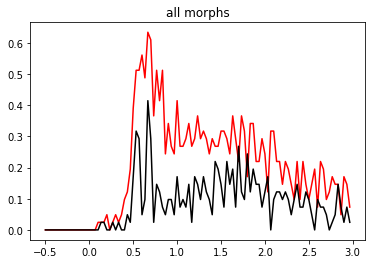

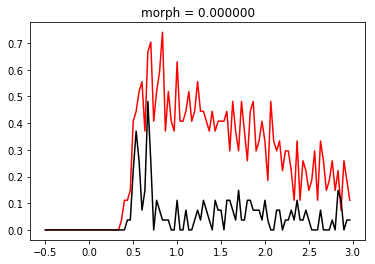

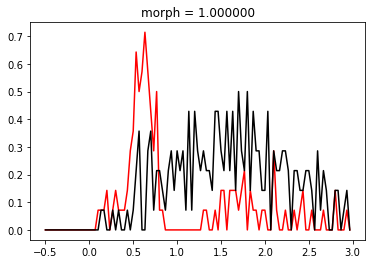

In [109]:
dat.plot_reward_trig_lick_rate(R[sessions[0]])

/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


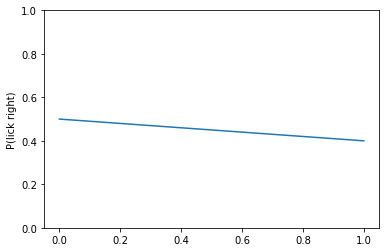

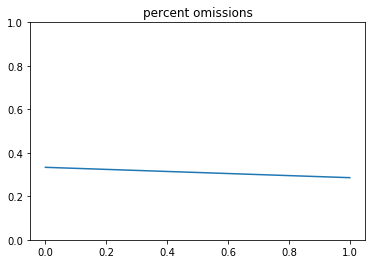

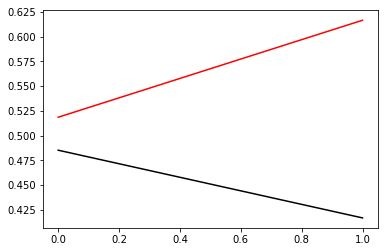

In [110]:
dat.plot_psychometric_curve(R['18_LR'])

In [48]:
print(R['14_LR']['first lick'])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 2.0, 2.0, 1.0, 2.0, 2.0, 2.0, 1.0, 2.0, 2.0, 2.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [38]:
print(R['14_LR']['RT'])

[0.5666666666666667, 0.4666666666666667, 0.5, 0.43333333333333335, 0.5, 0.4666666666666667, 0.5666666666666667, 0.4, 0.4666666666666667, 0.5333333333333333, 0.8333333333333334, 0.36666666666666664, 0.4666666666666667, 0.43333333333333335, 0.4666666666666667, 0.36666666666666664, 0.3333333333333333, 0.43333333333333335, 0.43333333333333335, 0.43333333333333335, 0.23333333333333334, 0.43333333333333335, 0.5333333333333333, 0.43333333333333335, 0.36666666666666664, 0.6, 0.7, 0.5, 0.5333333333333333, 0.36666666666666664, 0.43333333333333335, 0.4, 0.4, 0.3333333333333333, 0.43333333333333335, 0.36666666666666664, 0.4, 0.36666666666666664, 0.3, 0.36666666666666664, 0.36666666666666664, 0.3333333333333333, 0.26666666666666666, 0.4, 0.3333333333333333, 0.3333333333333333, 0.03333333333333333, 0.4, 0.3333333333333333, 0.36666666666666664, 0.3333333333333333, 0.43333333333333335, 0.5, 0.43333333333333335, 0.5666666666666667, 0.43333333333333335, 0.43333333333333335, 0.43333333333333335, 0.566666